In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy import interpolate
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

## Discussion about the outer envelope stellar mass as halo mass tracer

In [4]:
# Pre-compute
#s16a_precompute = os.path.join(data_dir, 'topn_public_s16a_medium_precompute.hdf5')

#hsc_pre = Table.read(s16a_precompute, path='hsc')

hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

data_use = hsc_pre[mask]

Text(0, 0.5, '$\\log (M_{\\star, [50, 100]}/ M_{\\odot})$')

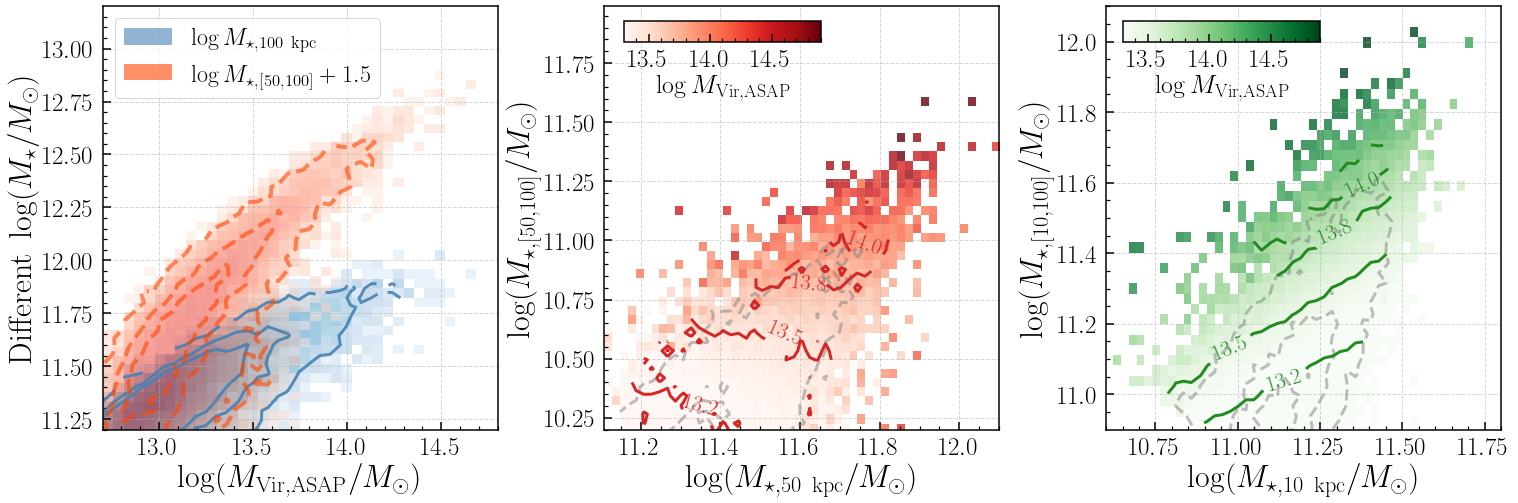

In [5]:
fig = plt.figure(figsize=(21, 7))
fig.subplots_adjust(
    left=0.065, bottom=0.15, right=0.99, top=0.99, wspace=0.27, hspace=None)

ax1 = fig.add_subplot(131)

# Tracer 1
z_stats_1, x_edges_1, y_edges_1, binnum_1 = binned_statistic_2d(
    data_use['logmh_vir_plane'], data_use['logm_100'], data_use['logm_10_100'], 
    'count', bins=[50, 22])
z_stats_1[z_stats_1 < 2] = np.nan

# Tracer 2
z_stats_2, x_edges_2, y_edges_2, binnum_2 = binned_statistic_2d(
    data_use['logmh_vir_plane'], data_use['logm_50_100'] + 1.5, data_use['logm_10_100'], 
    'count', bins=[50, 50])
z_stats_2[z_stats_2 < 2] = np.nan

HM_1 = ax1.imshow(
    z_stats_1.T, origin='lower', cmap='Blues', norm=LogNorm(vmin=1, vmax=2000),
    extent=[x_edges_1[0], x_edges_1[-1], y_edges_1[0], y_edges_1[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

HM_2 = ax1.imshow(
    z_stats_2.T, origin='lower', cmap='Reds', norm=LogNorm(vmin=1, vmax=2000),
    extent=[x_edges_2[0], x_edges_2[-1], y_edges_2[0], y_edges_2[-1]],
    aspect='auto', interpolation='nearest', alpha=0.5)

CT_1 = ax1.contour(
    x_edges_1[:-1], y_edges_1[:-1], gaussian_filter(z_stats_1.T, 0.12),
    5, linewidths=3.0, linestyles='solid', colors='steelblue', alpha=0.9, 
    levels=[8, 50, 100], extend='neither')

CT_2 = ax1.contour(
    x_edges_2[:-1], y_edges_2[:-1], gaussian_filter(z_stats_2.T, 0.12),
    5, linewidths=4.0, linestyles='dashed', colors='orangered', alpha=0.6, 
    levels=[8, 50, 100], extend='neither')

proxy = [plt.Rectangle((0,0), 1, 1, fc=c, alpha=0.6) for c in ['steelblue', 'orangered']]
ax1.legend(proxy, [r'$\log M_{\star, 100\ \rm kpc}$', r'$\log  M_{\star, [50, 100]} + 1.5$'],
           loc="upper left", fontsize=24)

ax1.set_xlim(12.7, 14.8)
ax1.set_ylim(11.2, 13.2)
ax1.set_xlabel(r'$\log (M_{\rm Vir, ASAP}/ M_{\odot})$', fontsize=32)
ax1.set_ylabel(r'${\rm Different\ } \log (M_{\star}/M_{\odot})$', fontsize=32)

ax2 = fig.add_subplot(133)

z_stats_3, x_edges_3, y_edges_3, binnum_3 = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[50, 60])
z_count_3, _, _, _ = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    'count', bins=[50, 60])
z_stats_3[z_stats_3 < 2] = np.nan
z_count_3[z_count_3 < 2] = np.nan

HM_3 = ax2.imshow(
    z_stats_3.T, origin='lower', cmap='Greens', vmin=13.3, vmax=14.9,
    extent=[x_edges_3[0], x_edges_3[-1], y_edges_3[0], y_edges_3[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_3 = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_count_3.T, 0.1),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[8, 50, 100], extend='neither')

CT_3b = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_stats_3.T, 0.2),
    4, linewidths=3.0, alpha=1.0, colors='forestgreen',
    levels=[13.2, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax2.clabel(CT_3b, inline=1, fontsize=22, colors='forestgreen', fmt=r'$%4.1f$')

ax2.set_xlim(10.6, 11.8)
ax2.set_ylim(10.9, 12.1)
ax2.set_xlabel(r'$\log (M_{\star, 10\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax2.set_ylabel(r'$\log (M_{\star, [10, 100]}/ M_{\odot})$', fontsize=32)

cax_3 = fig.add_axes([0.74, 0.92, 0.13, 0.04])
cbar_3 = plt.colorbar(HM_3, cax=cax_3, orientation='horizontal')
cbar_3.solids.set_edgecolor("face")
cax_3.set_xlabel(r'$\log M_{\rm Vir, ASAP}$', fontsize=26)

ax3 = fig.add_subplot(132)

z_stats_4, x_edges_4, y_edges_4, binnum_4 = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[50, 55])
z_count_4, _, _, _ = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    'count', bins=[50, 55])
z_stats_4[z_stats_4 < 2] = np.nan
z_count_4[z_count_4 < 2] = np.nan

HM_4 = ax3.imshow(
    z_stats_4.T, origin='lower', cmap='Reds', vmin=13.3, vmax=14.9,
    extent=[x_edges_4[0], x_edges_4[-1], y_edges_4[0], y_edges_4[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_4 = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_count_4.T, 0.1),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[8, 50, 200], extend='neither')

CT_4b = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_stats_4.T, 0.2),
    4, linewidths=3.0, alpha=1.0, colors='tab:red',
    levels=[13.2, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax3.clabel(CT_4b, inline=1, fontsize=22, colors='tab:red', fmt=r'$%4.1f$')
    
cax_4 = fig.add_axes([0.41, 0.92, 0.13, 0.04])
cbar_4 = plt.colorbar(HM_4, cax=cax_4, orientation='horizontal')
cbar_4.solids.set_edgecolor("face")
cax_4.set_xlabel(r'$\log M_{\rm Vir, ASAP}$', fontsize=26)

ax3.set_ylim(10.2, 11.99)
ax3.set_xlabel(r'$\log (M_{\star, 50\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax3.set_ylabel(r'$\log (M_{\star, [50, 100]}/ M_{\odot})$', fontsize=32)

In [22]:
fig.savefig(os.path.join(fig_dir, 'fig_12.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_12.pdf'), dpi=120)